In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!nvidia-smi

Tue Sep 20 15:12:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import os
import gc
import math
import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm
import re
import html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD, AdamW, RAdam
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import StratifiedKFold,StratifiedGroupKFold,GroupKFold
from sklearn.metrics import log_loss,f1_score

from transformers import AutoModel, AutoConfig, AutoTokenizer, AdamW, DataCollatorWithPadding
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup


from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
import catboost as ctb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed=42

In [6]:
DIR = '/content/drive/MyDrive/Competitions/Signate/MUFJ'
INPUT_DIR = os.path.join(DIR,'input')
OUTPUT_DIR = os.path.join(DIR,'output')
OUTPUT_SUB_DIR = os.path.join(OUTPUT_DIR,'submission')
#OUTPUT_MODEL_DIR = os.path.join(OUTPUT_DIR,'model')
OUTPUT_MODEL_DIR21 = DIR + '/output/model/EXP21/'
OUTPUT_MODEL_DIR43 = DIR + '/output/model/EXP43/'
OUTPUT_MODEL_DIR44 = DIR + '/output/model/EXP44/'
OUTPUT_MODEL_DIR45 = DIR + '/output/model/EXP45/'
OUTPUT_MODEL_DIR46 = DIR + '/output/model/EXP46/'

In [7]:
class CFG21:
    num_workers=4
    path=OUTPUT_MODEL_DIR21
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    custom_model2 = False

class CFG43:
    num_workers=4
    path=OUTPUT_MODEL_DIR43
    config_path=path+'config.pth'
    model="funnel-transformer/large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = False
    custom_model2 = False

class CFG44:
    num_workers=4
    path=OUTPUT_MODEL_DIR44
    config_path=path+'config.pth'
    model="microsoft/deberta-v3-large"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=True
    clean_content = True
    custom_model2 = False

class CFG45:
    num_workers=4
    path=OUTPUT_MODEL_DIR45
    config_path=path+'config.pth'
    model="facebook/bart-large-mnli"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=180
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=False
    freezing=False
    clean_content = False
    custom_model2 = True

class CFG46:
    num_workers=4
    path=OUTPUT_MODEL_DIR46
    config_path=path+'config.pth'
    model="microsoft/deberta-base"
    batch_size=32
    fc_dropout=0.2
    target_size=1
    max_len=256
    seed=42
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    gradient_checkpointing=True
    freezing=True
    clean_content = True
    custom_model2 = False

In [8]:
def get_score(labels, outputs):
    thresh = 0.5
    y_pred = outputs
    y_true = labels
    return f1_score(y_true, (y_pred>thresh).astype(int))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def get_logger(filename=OUTPUT_DIR+'/infrence'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=seed)

In [9]:
def freeze(module):
    """
    Freezes module's parameters.
    """
    
    for parameter in module.parameters():
        parameter.requires_grad = False
        
def get_freezed_parameters(module):
    """
    Returns names of freezed parameters of the given module.
    """
    
    freezed_parameters = []
    for name, parameter in module.named_parameters():
        if not parameter.requires_grad:
            freezed_parameters.append(name)
            
    return freezed_parameters

def set_embedding_parameters_bits(embeddings_path, optim_bits=32):
    """
    https://github.com/huggingface/transformers/issues/14819#issuecomment-1003427930
    """
    
    embedding_types = ("word", "position", "token_type")
    for embedding_type in embedding_types:
        attr_name = f"{embedding_type}_embeddings"
        
        if hasattr(embeddings_path, attr_name): 
            bnb.optim.GlobalOptimManager.get_instance().register_module_override(
                getattr(embeddings_path, attr_name), 'weight', {'optim_bits': optim_bits}
            )

In [10]:
oof_21 = pd.read_pickle(CFG21.path+'oof_df.pkl')
oof_43 = pd.read_pickle(CFG43.path+'oof_df.pkl')
oof_44 = pd.read_pickle(CFG44.path+'oof_df.pkl')
oof_45 = pd.read_pickle(CFG45.path+'oof_df.pkl')
oof_46 = pd.read_pickle(CFG46.path+'oof_df.pkl')

In [11]:
#labels = oof_df['state'].values
#preds = oof_df['pred'].values
#score = get_score(labels, preds)
#LOGGER.info(f'CV Score: {score:<.4f}')

In [12]:
train = pd.read_csv(os.path.join(INPUT_DIR,'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR,'test.csv'))
sub = pd.read_csv(os.path.join(INPUT_DIR,'sample_submit.csv'),header=None)
sub.columns = ['id','state']

In [13]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub('',text)

def remove_html(text):
    html=re.compile(r"<[^>]*?>")
    return html.sub('',text)

def cleaning(texts):
    clean_texts = []
    for text in texts:
        # htmlタグを削除
        text = remove_URL(text)
        text = remove_html(text)
        #アルファベット以外をスペースに置き換え
        #clean_punc = re.sub(r'[^a-zA-Z]', ' ', text)
        #改行削除
        #text = text.replace("\n","")
        clean_texts.append(text)
    return clean_texts

def get_goal_values(df):
  df["goal"].replace("100000+","100000-100000",inplace=True)
  _df = df["goal"].str.split('-').apply(pd.Series).astype(float)
  _df.columns = ["goal_max","goal_min"]
  df["goal_max"] = _df["goal_max"].astype(str)
  df["goal_min"] = _df["goal_min"].astype(str)
  df["goal_median"] = _df[["goal_max","goal_min"]].median(axis=1)
  df["goal_median"] = df["goal_median"].astype(int)
  return df

if CFG21.clean_content==True:
    p = re.compile(r"<[^>]*?>|&amp;|[/'’\"”]")

    test['html_content'] = test['html_content'].map(lambda x: str(x))
    test['html_content'] = test['html_content'].apply(html.unescape)
    test['html_content'] = test['html_content'].map(lambda x: p.sub("", x))
    test['html_content'] = test['html_content'].map(lambda x: x.lstrip())
    test['html_content'] = test['html_content'].fillna('missing')


test = get_goal_values(test)
test['inputs'] = test.goal_median.astype(str) + ' [SEP] ' + test.duration.astype(str) + ' [SEP] ' + test.country + ' [SEP] ' + test.category1 + ' [SEP] ' + test.category2 + ' [SEP] ' + test.html_content

In [14]:
# ====================================================
# tokenizer
# ====================================================
CFG21.tokenizer = AutoTokenizer.from_pretrained(CFG21.path+'tokenizer/')
CFG43.tokenizer = AutoTokenizer.from_pretrained(CFG43.path+'tokenizer/')
CFG44.tokenizer = AutoTokenizer.from_pretrained(CFG44.path+'tokenizer/')
CFG45.tokenizer = AutoTokenizer.from_pretrained(CFG45.path+'tokenizer/')
CFG46.tokenizer = AutoTokenizer.from_pretrained(CFG46.path+'tokenizer/')

In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False,
                           truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.inputs = df['inputs'].values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [16]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        #self.pool = MeanPooling()
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [17]:
class CustomModel2(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
            LOGGER.info(self.config)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        if self.cfg.gradient_checkpointing:
            self.model.gradient_checkpointing_enable()

        # Freezing
        if cfg.freezing:
            # freezing embeddings and first 2 layers of encoder
            freeze((self.model).embeddings)
            freeze((self.model).encoder.layer[:2])
            cfg.after_freezed_parameters = filter(lambda parameter: parameter.requires_grad, (self.model).parameters())

        #self.pool = MeanPooling()
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, cfg.target_size)
        #self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        #self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

In [18]:
def get_embeddings(df,path,cfg,plot_losses=True, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")

    if cfg.custom_model2:        
      model = CustomModel2(cfg, config_path=cfg.config_path, pretrained=False)
    else:
      model = CustomModel(cfg, config_path=cfg.config_path, pretrained=False)
    model.load_state_dict(torch.load(path)['model'])
    tokenizer = AutoTokenizer.from_pretrained(cfg.path+'tokenizer/')
    model.to(device)
    model.eval()

    
    ds = TestDataset(cfg, df)
    dl = DataLoader(ds,
                    batch_size=cfg.batch_size,
                    shuffle=False,
                    num_workers=cfg.num_workers, pin_memory=True, drop_last=False)
    
    embeddings = list()
    for batch in tqdm(dl, total=len(dl)):
        for k, v in batch.items():
            batch[k] = v.to(device)
        with torch.no_grad():
            model_output = model(batch)
            model_output = model_output.detach().cpu().numpy()
            embeddings.extend(model_output)
    return np.array(embeddings)

In [19]:
def get_embedding_feature(df,cfg,test_df):
    test_X = test_df.copy()
    oof_df = pd.DataFrame()
    embedding_tests = []
    for fold in range(4):
        X_train = df[df["kfold"] != fold]
        y_train = df[df["kfold"] != fold]['state']
        X_valid = df[df["kfold"] == fold]
        y_valid = df[df["kfold"] == fold]['state']
        #train_embeddings = get_embeddings(X_train,CFG.path+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        valid_embeddings = get_embeddings(X_valid,cfg.path+f"{cfg.model.replace('/', '-')}_fold{fold}_best.pth",cfg)
        test_embeddings = get_embeddings(test_X,cfg.path+f"{cfg.model.replace('/', '-')}_fold{fold}_best.pth",cfg)
        X_valid['embedding'] = valid_embeddings
        oof_df = pd.concat([oof_df,X_valid])
        embedding_tests.append(test_embeddings)
        del test_embeddings
        #break
    test_X['embedding'] = np.mean(embedding_tests, axis=0)
    return oof_df,test_X

In [20]:
embedding_21,test_21 = get_embedding_feature(oof_21,CFG21,test)
embedding_43,test_43 = get_embedding_feature(oof_43,CFG43,test)
embedding_44,test_44 = get_embedding_feature(oof_44,CFG44,test)
embedding_45,test_45 = get_embedding_feature(oof_45,CFG45,test)
embedding_46,test_46 = get_embedding_feature(oof_46,CFG46,test)

cuda is used


100%|██████████| 77/77 [00:54<00:00,  1.41it/s]


cuda is used


100%|██████████| 307/307 [03:40<00:00,  1.39it/s]


cuda is used


100%|██████████| 77/77 [00:56<00:00,  1.37it/s]


cuda is used


100%|██████████| 307/307 [03:41<00:00,  1.39it/s]


cuda is used


100%|██████████| 77/77 [00:56<00:00,  1.37it/s]


cuda is used


100%|██████████| 307/307 [03:41<00:00,  1.38it/s]


cuda is used


100%|██████████| 77/77 [00:56<00:00,  1.37it/s]


cuda is used


100%|██████████| 307/307 [03:41<00:00,  1.39it/s]


cuda is used


100%|██████████| 77/77 [01:49<00:00,  1.42s/it]


cuda is used


100%|██████████| 307/307 [07:13<00:00,  1.41s/it]


cuda is used


100%|██████████| 77/77 [01:49<00:00,  1.42s/it]


cuda is used


100%|██████████| 307/307 [07:14<00:00,  1.42s/it]


cuda is used


100%|██████████| 77/77 [01:49<00:00,  1.42s/it]


cuda is used


100%|██████████| 307/307 [07:15<00:00,  1.42s/it]


cuda is used


100%|██████████| 77/77 [01:49<00:00,  1.42s/it]


cuda is used


100%|██████████| 307/307 [07:13<00:00,  1.41s/it]


cuda is used


100%|██████████| 77/77 [02:50<00:00,  2.22s/it]


cuda is used


100%|██████████| 307/307 [11:23<00:00,  2.23s/it]


cuda is used


100%|██████████| 77/77 [02:51<00:00,  2.23s/it]


cuda is used


100%|██████████| 307/307 [11:25<00:00,  2.23s/it]


cuda is used


100%|██████████| 77/77 [02:51<00:00,  2.22s/it]


cuda is used


100%|██████████| 307/307 [11:22<00:00,  2.22s/it]


cuda is used


100%|██████████| 77/77 [02:51<00:00,  2.23s/it]


cuda is used


100%|██████████| 307/307 [11:22<00:00,  2.22s/it]


cuda is used


100%|██████████| 77/77 [01:47<00:00,  1.39s/it]


cuda is used


100%|██████████| 307/307 [07:04<00:00,  1.38s/it]


cuda is used


100%|██████████| 77/77 [01:46<00:00,  1.39s/it]


cuda is used


100%|██████████| 307/307 [07:04<00:00,  1.38s/it]


cuda is used


100%|██████████| 77/77 [01:46<00:00,  1.39s/it]


cuda is used


100%|██████████| 307/307 [07:03<00:00,  1.38s/it]


cuda is used


100%|██████████| 77/77 [01:46<00:00,  1.39s/it]


cuda is used


100%|██████████| 307/307 [07:04<00:00,  1.38s/it]


cuda is used


100%|██████████| 77/77 [00:57<00:00,  1.33it/s]


cuda is used


100%|██████████| 307/307 [03:46<00:00,  1.36it/s]


cuda is used


100%|██████████| 77/77 [00:57<00:00,  1.34it/s]


cuda is used


100%|██████████| 307/307 [03:46<00:00,  1.36it/s]


cuda is used


100%|██████████| 77/77 [00:57<00:00,  1.34it/s]


cuda is used


100%|██████████| 307/307 [03:46<00:00,  1.35it/s]


cuda is used


100%|██████████| 77/77 [00:57<00:00,  1.34it/s]


cuda is used


100%|██████████| 307/307 [03:47<00:00,  1.35it/s]


In [21]:
embedding_21.rename(columns={"embedding":"embedding_21"},inplace=True)
test_21.rename(columns={"embedding":"embedding_21"},inplace=True)
embedding_43.rename(columns={"embedding":"embedding_43"},inplace=True)
test_43.rename(columns={"embedding":"embedding_43"},inplace=True)
embedding_44.rename(columns={"embedding":"embedding_44"},inplace=True)
test_44.rename(columns={"embedding":"embedding_44"},inplace=True)
embedding_45.rename(columns={"embedding":"embedding_45"},inplace=True)
test_45.rename(columns={"embedding":"embedding_45"},inplace=True)
embedding_46.rename(columns={"embedding":"embedding_46"},inplace=True)
test_46.rename(columns={"embedding":"embedding_46"},inplace=True)

In [22]:
train_df = pd.read_csv(os.path.join(OUTPUT_DIR,"feature_train.csv"))
test_df = pd.read_csv(os.path.join(OUTPUT_DIR,"feature_test.csv"))
lgb_weak_train = pd.read_csv(os.path.join(OUTPUT_DIR,"weak_feature_lgbm_train.csv"))
lgb_weak_test = pd.read_csv(os.path.join(OUTPUT_DIR,"weak_feature_lgbm_test.csv"))


train_df = train_df.merge(lgb_weak_train[["id","weak_oof_prob"]],how="left",on="id").merge(embedding_21[["id","embedding_21"]],how="left",on="id").merge(embedding_43[["id","embedding_43"]],how="left",on="id").merge(embedding_44[["id","embedding_44"]],how="left",on="id").merge(embedding_45[["id","embedding_45"]],how="left",on="id").merge(embedding_46[["id","embedding_46"]],how="left",on="id")
test_df = test_df.merge(lgb_weak_test[["id","weak_oof_prob"]],how="left",on="id").merge(test_21[["id","embedding_21"]],how="left",on="id").merge(test_43[["id","embedding_43"]],how="left",on="id").merge(test_44[["id","embedding_44"]],how="left",on="id").merge(test_45[["id","embedding_45"]],how="left",on="id").merge(test_46[["id","embedding_46"]],how="left",on="id")

train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [23]:
skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=seed)
for fold, ( _, val_) in enumerate(skf.split(train_df, train_df.state)):
    train_df.loc[val_ , "kfold"] = int(fold)
    
train_df["kfold"] = train_df["kfold"].astype(int)

In [49]:
features = [
 #'country_category3_success_rate',
 #'prod_goal_duration',
 #'punct_percent',
 #'mean_word_len',
 #'ratio_goal_duration',
 #'count_sent',
 #'num_words_title',
 
 #'weak_oof_prob',
 'embedding_21',
 'embedding_43',
 'embedding_44',
 'embedding_45',
 'embedding_46',
]

In [50]:
def run():
    preds = []
    scores = []
    emb_df = pd.DataFrame()

    svmpreds_list = []
    logitpreds_list = []
    lgbpreds_list = []
    ctbpreds_list = []


    lgbm_params = {
    "objective":"binary",
    "metric":"binary_logloss",
    "n_estimators":1000,
    "random_state":seed
    }

    ctb_params = {
          "loss_function":"Logloss",
          "n_estimators":1000,
          "random_seed":seed,
          "learning_rate":0.05,
    }

    test_X = test_df[features].values

    for fold in range(5):

        print()
        print('fold  :  ',fold)

        train_dataset = train_df.loc[train_df.kfold!=fold].reset_index(drop=True)
        valid_dataset = train_df.loc[train_df.kfold==fold].reset_index(drop=True)

        y_train = train_dataset.state
        x_train = train_dataset[features].values
        y_valid = valid_dataset.state
        x_valid = valid_dataset[features].values

        model_svc = SVC(C=5,kernel='rbf',gamma='auto',probability=True,random_state=seed)
        model_logit = LogisticRegression(random_state=seed)
        model_lgb = lgb.LGBMClassifier(**lgbm_params)
        model_ctb = ctb.CatBoostClassifier(**ctb_params)

        model_svc.fit(x_train,y_train)
        model_logit.fit(x_train,y_train)
        model_lgb.fit(x_train, y_train, eval_set=(x_valid, y_valid), early_stopping_rounds=100,
               verbose=500)
        model_ctb.fit(x_train, y_train,
            eval_set=[(x_train, y_train),(x_valid, y_valid)],
            verbose = 500,
            early_stopping_rounds = 100)


        prediction_svm = model_svc.predict_proba(x_valid)
        prediction_svm = prediction_svm[:,1]
        prediction_logit = model_logit.predict_proba(x_valid)
        prediction_logit = prediction_logit[:,1]
        prediction_lgb = model_lgb.predict_proba(x_valid)
        prediction_lgb = prediction_lgb[:,1]
        prediction_ctb = model_ctb.predict_proba(x_valid)
        prediction_ctb = prediction_ctb[:,1]

        print(f"SVM : {get_score(y_valid, prediction_svm)}")
        print(f"Logit : {get_score(y_valid, prediction_logit)}")
        print(f"LGBM : {get_score(y_valid, prediction_lgb)}")
        print(f"CTB : {get_score(y_valid, prediction_ctb)}")


        valid_dataset["embedding_svm"] = prediction_svm
        valid_dataset["embedding_logit"] = prediction_logit
        valid_dataset["embedding_lgb"] = prediction_lgb
        valid_dataset["embedding_ctb"] = prediction_ctb
        emb_df = pd.concat([emb_df,valid_dataset])


        tmp_svm = model_svc.predict_proba(test_X)
        predssvm = tmp_svm[:,1]
        tmp_logit = model_logit.predict_proba(test_X)
        predslogit = tmp_logit[:,1]
        tmp_lgb = model_lgb.predict_proba(test_X)
        predslgb = tmp_lgb[:,1]
        tmp_ctb = model_ctb.predict_proba(test_X)
        predsctb = tmp_ctb[:,1]
        

        svmpreds_list.append(predssvm)
        logitpreds_list.append(predslogit)
        lgbpreds_list.append(predslgb)
        ctbpreds_list.append(predsctb)

    preds_svm = np.mean(svmpreds_list,axis=0)
    preds_logit = np.mean(logitpreds_list,axis=0)
    preds_lgb = np.mean(lgbpreds_list,axis=0)
    preds_ctb = np.mean(ctbpreds_list,axis=0)
    
    return preds_svm,preds_logit,preds_lgb,preds_ctb,emb_df

In [51]:
preds_svm,preds_logit,preds_lgb,preds_ctb,oof_embedding = run()


fold  :   0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.376578
0:	learn: 0.6587981	test: 0.6588254	test1: 0.6607300	best: 0.6607300 (0)	total: 4.65ms	remaining: 4.65s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3730191293
bestIteration = 95

Shrink model to first 96 iterations.
SVM : 0.7915811088295689
Logit : 0.8167701863354038
LGBM : 0.8152284263959391
CTB : 0.819755600814664

fold  :   1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.388544
0:	learn: 0.6580099	test: 0.6580392	test1: 0.6610867	best: 0.6610867 (0)	total: 4.21ms	remaining: 4.21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3879314592
bestIteration = 203

Shrink model to first 204 iterations.
SVM : 0.7942681678607986
Logit : 0.8091286307053942
LGBM : 0.8103896103896104
CTB : 0.8099947943779281

fold  : 

In [41]:
oof_embedding.to_csv(os.path.join(OUTPUT_DIR,"embedding_oof.csv"),index=False)

In [52]:
svm_oof = oof_embedding["embedding_svm"]
logit_oof = oof_embedding["embedding_logit"]
lgb_oof = oof_embedding["embedding_lgb"]
ctb_oof = oof_embedding["embedding_ctb"]

embedding_oof = (logit_oof+lgb_oof+ctb_oof)/3
labels = oof_embedding["state"].astype(int)
score = get_score(labels, embedding_oof)
print(f'CV Score: {score:<.4f}')

CV Score: 0.8234


In [53]:
submit = sub.copy()
#submit.columns = ["id","label"]

embedding_predictions = (preds_logit+preds_ctb+preds_lgb)/3

submit['label'] = embedding_predictions
submit['state'] = (embedding_predictions>0.5).astype(int)

#submit[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp103_embedding_submission.csv"),index=False,header=False)
submit[["id","state"]].to_csv(os.path.join(OUTPUT_SUB_DIR,"exp103_embeddingonly_submission8234.csv"),index=False,header=False)
display(submit)

,id,state,label
0,test_00000,1,0.580187
1,test_00001,1,0.985898
2,test_00002,1,0.880495
3,test_00003,0,0.115474
4,test_00004,0,0.088968
...,...,...,...
9795,test_09795,1,0.556360
9796,test_09796,1,0.987458
9797,test_09797,0,0.251151
9798,test_09798,1,0.668273


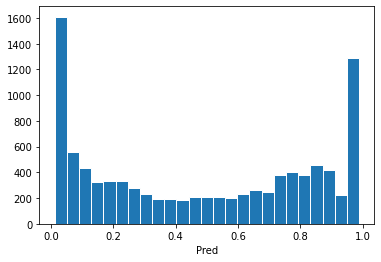

In [54]:
plt.hist(submit.label,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

In [55]:
#train,testでダブっているデータを参照
dup_test_ids = ['test_01704','test_03707','test_04353','test_04453','test_04645','test_06909','test_08232']
sub_dup= submit[submit["id"].isin(dup_test_ids)]

In [56]:
T = pd.DataFrame([['train_00365','train_01463','train_02156','train_04506','train_06891','train_08302','train_09470'],
                [0,1,1,1,1,1,0],
                ['test_08232','test_01704','test_06909','test_04453','test_03707','test_04353','test_04645']]).T
T.columns =["train id","true label","id"]
T = T.sort_values(by="id")
T = T.merge(sub_dup,how='left',on='id')
T

,train id,true label,id,state,label
0,train_01463,1,test_01704,1,0.983205
1,train_06891,1,test_03707,1,0.982227
2,train_08302,1,test_04353,1,0.769764
3,train_04506,1,test_04453,1,0.985688
4,train_09470,0,test_04645,0,0.259861
5,train_02156,1,test_06909,1,0.636720
6,train_00365,0,test_08232,0,0.175284
